In [149]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [150]:
import numpy as np

Data Generation

In [151]:
np.random.seed(45)
num_samples = 40

x1 = np.random.uniform(-1, 1, num_samples)
f_x = 3*x1 + 4
eps = np.random.randn(num_samples)
y = f_x + eps

Q1) Use torch.autograd to find the true gradient on the above dataset using linear regression (in the form θ1x+θ0) for any given values of (θ0,θ1). [1 mark]

Preprocessing Input Data

In [152]:
x1 = torch.from_numpy(x1)
x1 = x1.reshape(40,1)
ones = torch.ones(40, 1)
x1 = torch.cat((ones, x1), dim=1)
x1.float()
print(x1.shape)

# Normal equation using PyTorch
theta_optimal = torch.inverse(x1.T @ x1) @ (x1.T @ y)
def MSE_loss(X, y, theta):
    N = len(y)
    y_pred = X @ theta
    return (1 / N) * torch.sum((y_pred - y) ** 2)
loss_minima = MSE_loss(x1, y, theta_optimal)
print("Theta optimal:", theta_optimal)
print("Minimal Loss:", loss_minima)

torch.Size([40, 2])
Theta optimal: tensor([3.9507, 2.6825], dtype=torch.float64)
Minimal Loss: tensor(0.5958, dtype=torch.float64)


Linear Regression Model

In [153]:
theta = np.array([0.0,0.0]).reshape(2,1)
theta = torch.tensor(theta, requires_grad=True, dtype=torch.float64)
print("Theta: ", theta.shape)

y = torch.from_numpy(y)
y_pred = x1@theta
print("Y_pred: ",y_pred.shape)

y = y.reshape(40,1)
cost = torch.mean((y_pred - y) ** 2)
cost.backward()

theta.grad
true_grad = theta.grad.clone()

Theta:  torch.Size([2, 1])
Y_pred:  torch.Size([40, 1])


Q2) Using the same (θ0,θ1) as above, calculate the stochastic gradient for all points in the dataset. Then, find the average of all those gradients and show that the stochastic gradient is a good estimate of the true gradient. [1 mark]

In [154]:
theta.grad.zero_()

stochastic_grads = torch.zeros_like(theta)

for i in range(num_samples):
    xi = x1[i:i+1]
    yi = y[i:i+1]

    y_pred_i = xi @ theta
    loss_i = torch.mean((y_pred_i - yi) ** 2)

    loss_i.backward()
    stochastic_grads += theta.grad
    # print("gradient using SGD: ", theta.grad)
    theta.grad.zero_()

stochastic_grads /= num_samples

print("True Gradient: \n", true_grad)
print("Stochastic Gradient (Averaged): \n", stochastic_grads)

True Gradient: 
 tensor([[-7.4471],
        [-1.0253]], dtype=torch.float64)
Stochastic Gradient (Averaged): 
 tensor([[-7.4471],
        [-1.0253]], dtype=torch.float64)


Q3) Implement full-batch, mini-batch and stochastic gradient descent. Calculate the average number of iterations required for each method to get sufficiently close to the optimal solution, where "sufficiently close" means within a distance of
ϵ
 (or
ϵ
-neighborhood) from the minimum value of the loss function. Visualize the convergence process for 15 epochs. Choose
ϵ
=
0.001
 for convergence criteria. Which optimization process takes a larger number of epochs to converge, and why? Show the contour plots for different epochs (or show an animation/GIF) for visualisation of optimisation process. Also, make a plot for Loss v/s epochs for all the methods. [2 marks]

Normal eqn for finding optimal theta

$ \theta = (X^T X)^{-1} X^T y $




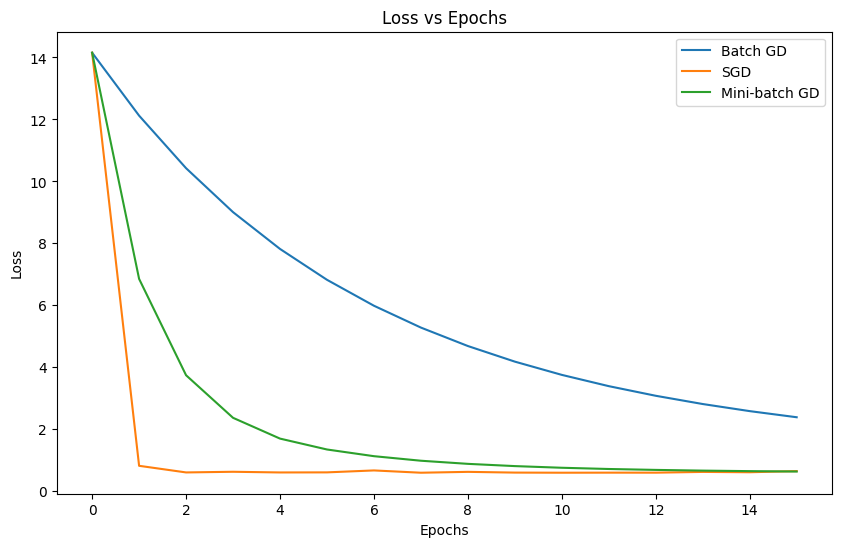

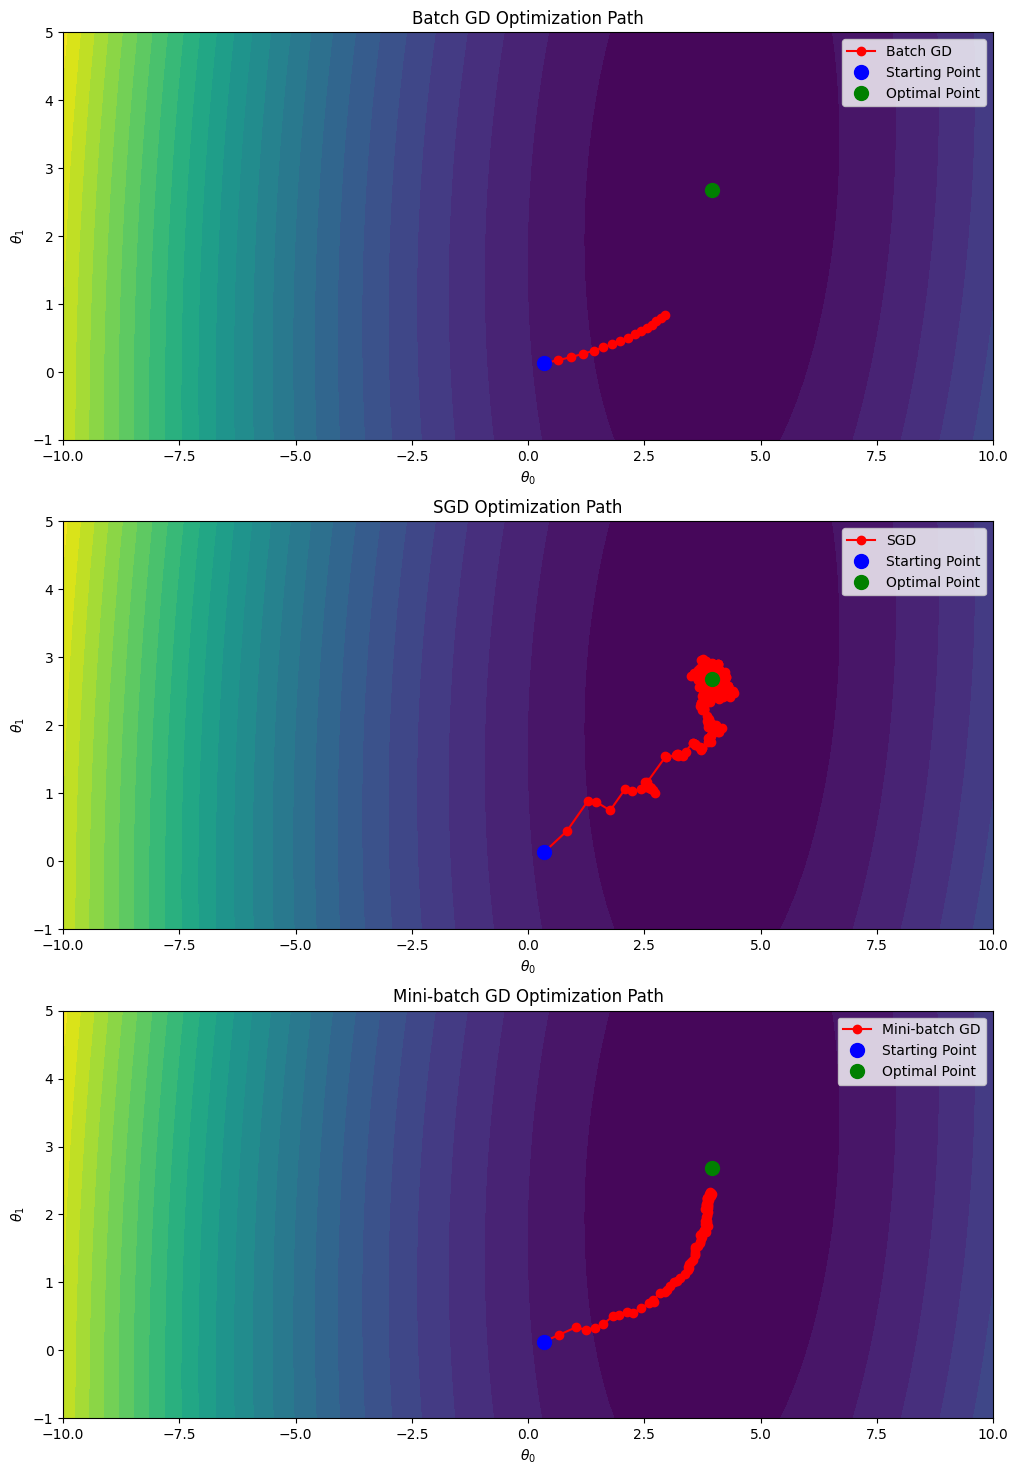

In [155]:
import matplotlib.pyplot as plt

def MSE_loss(X, y, theta):
    N = len(y)
    y_pred = X @ theta
    return (1 / N) * torch.sum((y_pred - y) ** 2)

def gradient_descent(X, y, theta, learning_rate=0.01, n_epochs=15, method='batch', batch_size=8, epsilon=0.001):
    N = len(y)
    loss_init = MSE_loss(X, y, theta)
    losses = [loss_init]
    theta_history = [theta.clone()]

    converged_epoch = 0
    converged_iter = 0

    for epoch in range(n_epochs):
        if method == 'batch':
            gradients = (1/N) * X.T @ (X @ theta - y)
            theta -= learning_rate * gradients

            theta_history.append(theta.clone())


        elif method == 'sgd':
            indices = torch.randperm(x1.size(0))
            x1_shuffled = x1[indices]
            y_shuffled = y[indices]
            for i in range(N):
                xi = x1_shuffled[i].unsqueeze(0)
                yi = y_shuffled[i].unsqueeze(0)
                gradients = xi.T @ (xi @ theta - yi)
                theta -= learning_rate * gradients

                theta_history.append(theta.clone())


        elif method == 'minibatch':
            indices = torch.randperm(x1.size(0))
            x1_shuffled = x1[indices]
            y_shuffled = y[indices]

            for i in range(0, N, batch_size):
                X_i = x1_shuffled[i : i + batch_size]
                y_i = y_shuffled[i : i + batch_size]
                gradients = (1 / batch_size) * X_i.T @ (X_i @ theta - y_i)
                theta -= learning_rate * gradients
                theta_history.append(theta.clone())



        loss = MSE_loss(X, y, theta)
        losses.append(loss.item())

        # if(epoch%100==0):
        # print(f"Loss at {epoch} is ", loss, "Optimal Theta: ", theta_optimal, "Theta: ", theta.clone(), "Norm:" , torch.linalg.vector_norm(theta_optimal-theta.clone().squeeze()))

        if torch.linalg.vector_norm(theta_optimal-theta.clone().squeeze())  < epsilon:
            print(f"Converged at epoch {epoch}")
            converged_epoch=epoch
            if method == 'batch':
              converged_iter=epoch
              print("No of iters: ", epoch)
            elif method == 'sgd':
              converged_iter=epoch*num_samples
              print("No of iters: ", epoch*num_samples)
            elif method == 'minibatch':
              converged_iter=epoch*(num_samples/batch_size)
              print("No of iters: ", epoch*(num_samples/batch_size))


            break

    return theta, losses, theta_history, converged_epoch, converged_iter

torch.manual_seed(42)
theta_initial = torch.randn(2, 1, dtype=torch.float64)

theta_batch,loss_batch, history_batch, _, _ = gradient_descent(x1, y, theta_initial.clone(), method='batch',  learning_rate=0.09)
theta_sgd, loss_sgd, history_sgd, _, _ = gradient_descent(x1, y, theta_initial.clone(), method='sgd',  learning_rate=0.09)
theta_mbgd, loss_mbgd, history_mbgd, _, _ = gradient_descent(x1, y, theta_initial.clone(), method='minibatch',  learning_rate=0.09)


plt.figure(figsize=(10, 6))
plt.plot(loss_batch, label='Batch GD')
plt.plot(loss_sgd, label='SGD')
plt.plot(loss_mbgd, label='Mini-batch GD')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

def plot_contours(ax, X, y, theta_history, method_name):
    theta0_vals = np.linspace(-10, 10, 100)
    theta1_vals = np.linspace(-1, 5, 100)
    J_vals = np.zeros((len(theta0_vals), len(theta1_vals)))

    for i, theta0 in enumerate(theta0_vals):
        for j, theta1 in enumerate(theta1_vals):
            t = torch.tensor([[theta0], [theta1]], dtype=torch.float64)
            J_vals[i, j] = MSE_loss(X, y, t)

    theta0_vals, theta1_vals = np.meshgrid(theta0_vals, theta1_vals)

    ax.contourf(theta0_vals, theta1_vals, J_vals.T, levels=30, cmap='viridis')
    ax.plot([t[0].item() for t in theta_history], [t[1].item() for t in theta_history], 'r-o', label=method_name)

    ax.plot(history_batch[0][0].item(), history_batch[0][1].item(), 'bo', label='Starting Point', markersize=10)

    ax.plot(theta_optimal[0].item(), theta_optimal[1].item(), 'go', label='Optimal Point', markersize=10)

    ax.set_xlabel(r'$\theta_0$')
    ax.set_ylabel(r'$\theta_1$')
    ax.set_title(f'{method_name} Optimization Path')
    ax.legend()

fig, axes = plt.subplots(3, 1, figsize=(12, 18))
axes[0].set_title("Batch Gradient Descent")
axes[1].set_title("Stochastic Gradient Descent")
axes[2].set_title("Mini-batch Gradient Descent")

plot_contours(axes[0], x1, y, history_batch, 'Batch GD')
plot_contours(axes[1], x1, y, history_sgd, 'SGD')
plot_contours(axes[2], x1, y, history_mbgd, 'Mini-batch GD')


In [156]:
import matplotlib.animation as animation
def animate_optimization(theta_history, ax, method_name):
    def update(epoch):
        ax.clear()
        plot_contours(ax, x1, y, theta_history[:epoch+1], method_name)
        ax.set_title(f"{method_name} - Epoch {epoch+1}/{len(theta_history)}")
    return update


def create_and_save_animation(theta_history, method_name, filename):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title(f"{method_name} Gradient Descent")
    anim = animation.FuncAnimation(fig, animate_optimization(theta_history, ax, method_name), frames=len(theta_history), repeat=False)
    anim.save(filename, writer='pillow')
    plt.close(fig)

create_and_save_animation(history_batch, 'Batch GD', 'batch_gd_15.gif')
create_and_save_animation(history_sgd, 'SGD', 'sgd_15.gif')
create_and_save_animation(history_mbgd, 'Mini-batch GD', 'minibatch_gd_15.gif')

print(f'Animations saved for 15 epochs: batch_gd.gif, sgd.gif, minibatch_gd.gif')


plt.show()

Animations saved for 15 epochs: batch_gd.gif, sgd.gif, minibatch_gd.gif


No of iterations

Vanilla BG: 15

SGD: 15*40 = 600

Mini-batch GD: 15xbatch_size = 15x5 = 75

In [178]:
mean_epoch = np.array([0.0, 0.0, 0.0])
mean_iter = np.array([0.0, 0.0, 0.0])

for i in range(15):
  theta_batch,loss_batch, history_batch, e, i = gradient_descent(x1, y, theta_initial.clone(), method='batch', n_epochs=2000, learning_rate=0.05)
  mean_epoch[0] += e
  mean_iter[0] += i
  theta_sgd, loss_sgd, history_sgd, e, i = gradient_descent(x1, y, theta_initial.clone(), method='sgd', n_epochs=4000,  learning_rate=0.05)
  mean_epoch[1] += e
  mean_iter[1] += i
  theta_mbgd, loss_mbgd, history_mbgd, e, i = gradient_descent(x1, y, theta_initial.clone(), method='minibatch', n_epochs=2000,  learning_rate=0.05)
  mean_epoch[2] += e
  mean_iter[2] += i

Converged at epoch 519
No of iters:  519
Converged at epoch 1183
No of iters:  47320
Converged at epoch 107
No of iters:  535.0
Converged at epoch 519
No of iters:  519
Converged at epoch 97
No of iters:  485.0
Converged at epoch 519
No of iters:  519
Converged at epoch 120
No of iters:  600.0
Converged at epoch 519
No of iters:  519
Converged at epoch 2309
No of iters:  92360
Converged at epoch 98
No of iters:  490.0
Converged at epoch 519
No of iters:  519
Converged at epoch 2535
No of iters:  101400
Converged at epoch 99
No of iters:  495.0
Converged at epoch 519
No of iters:  519
Converged at epoch 2851
No of iters:  114040
Converged at epoch 128
No of iters:  640.0
Converged at epoch 519
No of iters:  519
Converged at epoch 428
No of iters:  17120
Converged at epoch 124
No of iters:  620.0
Converged at epoch 519
No of iters:  519
Converged at epoch 870
No of iters:  34800
Converged at epoch 104
No of iters:  520.0
Converged at epoch 519
No of iters:  519
Converged at epoch 2990
No

In [179]:
mean_epoch/=15
mean_iter/=15
names = ["Batch GD", "SGD", "Mini Batch"]
for i in range(3):
  print(names[i])
  print(f"Converges at {mean_epoch[i]} epochs")
  print(f"Converges at {mean_iter[i]} iters")


Batch GD
Converges at 519.0 epochs
Converges at 519.0 iters
SGD
Converges at 1664.7333333333333 epochs
Converges at 66589.33333333333 iters
Mini Batch
Converges at 107.8 epochs
Converges at 539.0 iters


##Which optimization process takes a larger number of epochs to converge, and why?

For a learning rate of 0.05 Batch GD takes the max no of epochs to converge. This is because the steps are very small and even though the convergence path might be very smooth, it takes a lot more epochs to converge

Even though each individual SGD update is noisier, the frequent parameter updates allow the model to make faster progress early on, which can lead to quicker convergence in terms of epochs. This again depends on the learning rate for a learning rate of 0.5 as shown in below cells GD converges faster than SGD

Minibatch divides the entire dataset into batches and updates theta for every batch of data. For a learning rate of 0.05 it converges the fastest among the 3 approaches. This can be explained by the fact that the updates are more frequent and even though they are a bit noisy. The large no of updates(compared to GD) is able to compensate for this and so it converges the fastest.


Batch size is another hyperparamter which is important when talking about the convergence beacause the no of updates depends

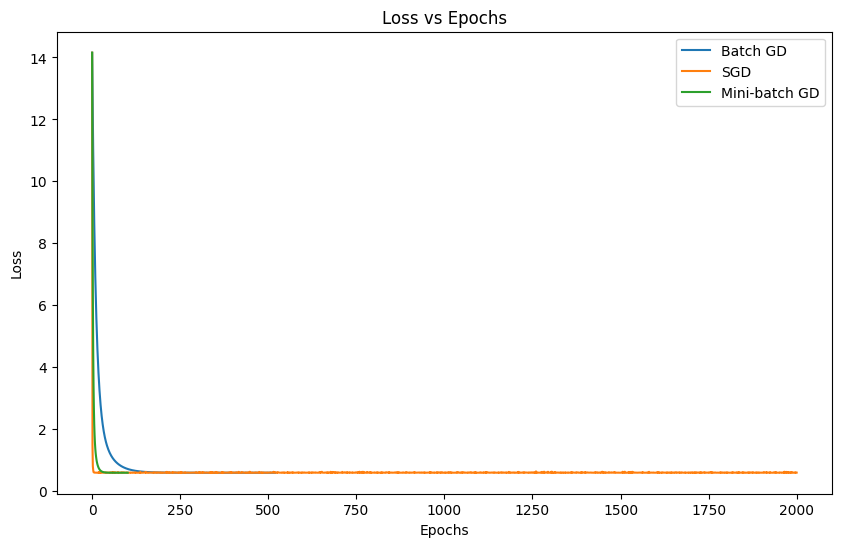

In [159]:
plt.figure(figsize=(10, 6))
plt.plot(loss_batch, label='Batch GD')
plt.plot(loss_sgd, label='SGD')
plt.plot(loss_mbgd, label='Mini-batch GD')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

##Choosing the hyperparameter learning_rate

Observations from the below experiments

1) 0.5 is a good Learning rate of for SGD as it converges in 48 epochs

2) 0.01 is a good Learning rate of for SGD as it converges in 69 epochs

3) 0.1 is a good Learning rate for minibatch GD since is converges in 55 epochs

For Vanilla GD

In [160]:
print("Learning rate: ", 0.5)
theta_batch,loss_batch, history_batch, e, i = gradient_descent(x1, y, theta_initial.clone(), method='batch', n_epochs=2400, learning_rate=0.5)
print()
print("Learning rate: ", 0.1)

theta_batch,loss_batch, history_batch, e, i = gradient_descent(x1, y, theta_initial.clone(), method='batch', n_epochs=2400, learning_rate=0.1)
print()
print("Learning rate: ", 0.09)
theta_batch,loss_batch, history_batch, e, i = gradient_descent(x1, y, theta_initial.clone(), method='batch', n_epochs=2400, learning_rate=0.09)
print()
print("Learning rate: ", 0.05)
theta_batch,loss_batch, history_batch, e, i = gradient_descent(x1, y, theta_initial.clone(), method='batch', n_epochs=2400, learning_rate=0.05)
print()
print("Learning rate: ", 0.01)
theta_batch,loss_batch, history_batch, e, i = gradient_descent(x1, y, theta_initial.clone(), method='batch', n_epochs=2400, learning_rate=0.01)


Learning rate:  0.5
Converged at epoch 48
No of iters:  48

Learning rate:  0.1
Converged at epoch 257
No of iters:  257

Learning rate:  0.09
Converged at epoch 286
No of iters:  286

Learning rate:  0.05
Converged at epoch 519
No of iters:  519

Learning rate:  0.01


Learning rate of 0.5 is better as Vanilla GD converges in 48 epochs

For SGD

In [177]:
print("Learning rate: ", 0.5)
# theta_sgd, loss_sgd, history_sgd, e, i = gradient_descent(x1, y, theta_initial.clone(), method='sgd', n_epochs=1000,  learning_rate=0.5)
print("Learning rate: ", 0.1)
# theta_sgd, loss_sgd, history_sgd, e, i = gradient_descent(x1, y, theta_initial.clone(), method='sgd', n_epochs=1000,  learning_rate=0.1)
print("Learning rate: ", 0.09)
theta_sgd, loss_sgd, history_sgd, e, i = gradient_descent(x1, y, theta_initial.clone(), method='sgd', n_epochs=1000,  learning_rate=0.09)
print("Learning rate: ", 0.05)
theta_sgd, loss_sgd, history_sgd, e, i = gradient_descent(x1, y, theta_initial.clone(), method='sgd', n_epochs=5000,  learning_rate=0.05)
print()
print("Learning rate: ", 0.01)
theta_sgd, loss_sgd, history_sgd, e, i = gradient_descent(x1, y, theta_initial.clone(), method='sgd', n_epochs=1000,  learning_rate=0.01)
print()
print("Learning rate: ", 0.009)
theta_sgd, loss_sgd, history_sgd, e, i = gradient_descent(x1, y, theta_initial.clone(), method='sgd', n_epochs=1000,  learning_rate=0.009)
print()
print("Learning rate: ", 0.005)
theta_sgd, loss_sgd, history_sgd, e, i = gradient_descent(x1, y, theta_initial.clone(), method='sgd', n_epochs=1000,  learning_rate=0.005)
print()
print("Learning rate: ", 0.001)
theta_sgd, loss_sgd, history_sgd, e, i = gradient_descent(x1, y, theta_initial.clone(), method='sgd', n_epochs=1000,  learning_rate=0.001)

Learning rate:  0.5
Learning rate:  0.1
Learning rate:  0.09
Learning rate:  0.05
Converged at epoch 2863
No of iters:  114520

Learning rate:  0.01
Converged at epoch 75
No of iters:  3000

Learning rate:  0.009
Converged at epoch 128
No of iters:  5120

Learning rate:  0.005
Converged at epoch 136
No of iters:  5440

Learning rate:  0.001
Converged at epoch 653
No of iters:  26120


0.01 is a good Learning rate for SGD as it converges in 69 epochs

For MiniBatch GD

In [162]:
print("Learning rate: ", 0.5)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent(x1, y, theta_initial.clone(), method='minibatch', n_epochs=1000,  learning_rate=0.5)
print()
print("Learning rate: ", 0.1)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent(x1, y, theta_initial.clone(), method='minibatch', n_epochs=1000,  learning_rate=0.1)
print()
print("Learning rate: ", 0.09)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent(x1, y, theta_initial.clone(), method='minibatch', n_epochs=1000,  learning_rate=0.09)
print()
print("Learning rate: ", 0.05)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent(x1, y, theta_initial.clone(), method='minibatch', n_epochs=1000,  learning_rate=0.05)
print()
print("Learning rate: ", 0.01)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent(x1, y, theta_initial.clone(), method='minibatch', n_epochs=1000,  learning_rate=0.01)
print()
print("Learning rate: ", 0.009)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent(x1, y, theta_initial.clone(), method='minibatch', n_epochs=1000,  learning_rate=0.009)
print()
print("Learning rate: ", 0.005)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent(x1, y, theta_initial.clone(), method='minibatch', n_epochs=1000,  learning_rate=0.005)
print()
print("Learning rate: ", 0.001)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent(x1, y, theta_initial.clone(), method='minibatch', n_epochs=1000,  learning_rate=0.001)

Learning rate:  0.5

Learning rate:  0.1
Converged at epoch 145
No of iters:  725.0

Learning rate:  0.09
Converged at epoch 105
No of iters:  525.0

Learning rate:  0.05
Converged at epoch 109
No of iters:  545.0

Learning rate:  0.01
Converged at epoch 530
No of iters:  2650.0

Learning rate:  0.009
Converged at epoch 582
No of iters:  2910.0

Learning rate:  0.005

Learning rate:  0.001


0.1 is a good Learning rate for minibatch GD since is converges in 55 epochs

In [163]:
# create_and_save_animation(history_batch, 'Batch GD', 'batch_gd.gif')
# create_and_save_animation(history_sgd, 'SGD', 'sgd.gif')
# create_and_save_animation(history_mbgd, 'Mini-batch GD', 'minibatch_gd.gif')

# print(f'Animations saved for convergence: batch_gd.gif, sgd.gif, minibatch_gd.gif')

Q4) Explore the article here on gradient descent with momentum. Implement gradient descent with momentum for the dataset. Visualize the convergence process for 15 steps. Compare the average number of steps taken with gradient descent (for variants full batch and stochastic) with momentum to that of vanilla gradient descent to converge to an
ϵ
-neighborhood for both dataset. Choose
ϵ
=
0.001
. Write down your observations. Show the contour plots for different epochs for momentum implementation. Specifically, show all the vectors: gradient, current value of theta, momentum, etc. [2 marks]

A **problem** with gradient descent is that it can bounce around the search space on optimization problems that have large amounts of curvature or noisy gradients, and it can get stuck in flat spots in the search space that have **no gradient**.

Momentum is an extension to the gradient descent optimization algorithm that allows the search to build inertia in a direction in the search space and overcome the oscillations of noisy gradients and coast across flat spots of the search space.

If the step size is too small, the movement in the search space will be small and the search will take a long time. If the step size is too large, the search may bounce around the search space and skip over the optima.

Momentum is an extension to the gradient descent optimization algorithm, often referred to as gradient descent with momentum.

It is designed to accelerate the optimization process, e.g. decrease the number of function evaluations required to reach the optima, or to improve the capability of the optimization algorithm, e.g. result in a better final result.

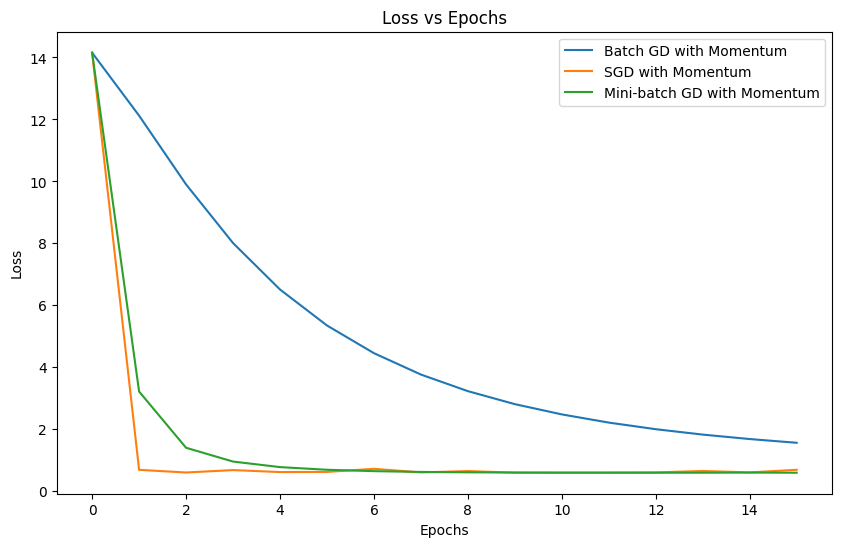

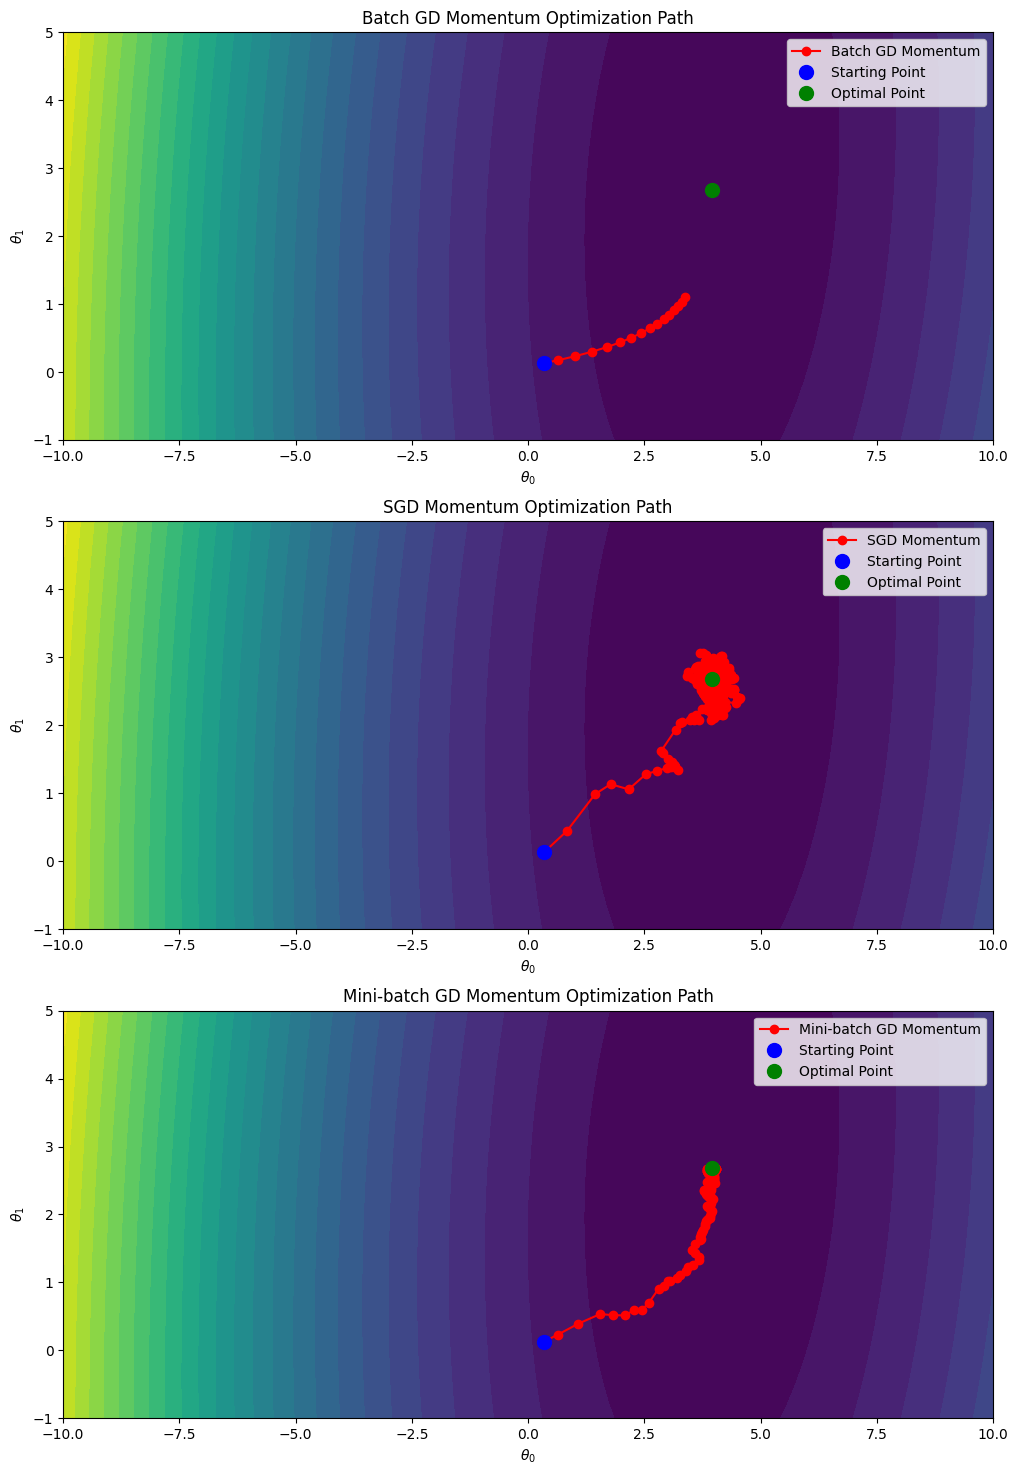

In [164]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def MSE_loss(X, y, theta):
    N = len(y)
    y_pred = X @ theta
    return (1 / N) * torch.sum((y_pred - y) ** 2)

def gradient_descent_with_momentum(X, y, theta, learning_rate=0.01, n_epochs=15, method='batch', batch_size=5, epsilon=0.001, momentum=0.3):
    N = len(y)
    loss_init = MSE_loss(X, y, theta)
    losses = [loss_init]
    theta_history = [theta.clone()]
    change = torch.zeros_like(theta)

    converged_epoch = 0
    converged_iter = 0

    for epoch in range(n_epochs):
        if method == 'batch':
            gradients = (1 / N) * X.T @ (X @ theta - y)
            new_change = learning_rate * gradients + momentum * change
            theta -= new_change
            change = new_change
            theta_history.append(theta.clone())

        elif method == 'sgd':
            indices = torch.randperm(X.size(0))
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            for i in range(N):
                xi = X_shuffled[i].unsqueeze(0)
                yi = y_shuffled[i].unsqueeze(0)
                gradients = xi.T @ (xi @ theta - yi)
                new_change = learning_rate * gradients + momentum * change
                theta -= new_change
                change = new_change
                theta_history.append(theta.clone())

        elif method == 'minibatch':
            indices = torch.randperm(X.size(0))
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for i in range(0, N, batch_size):
                X_i = X_shuffled[i : i + batch_size]
                y_i = y_shuffled[i : i + batch_size]
                gradients = (1 / batch_size) * X_i.T @ (X_i @ theta - y_i)
                new_change = learning_rate * gradients + momentum * change
                theta -= new_change
                change = new_change
                theta_history.append(theta.clone())

        loss = MSE_loss(X, y, theta)
        losses.append(loss.item())
        # theta_history.append(theta.clone())

        # if epoch % 100 == 0:
        #     print(f"Loss at epoch {epoch}: {loss.item()}")

        if torch.linalg.vector_norm(theta_optimal-theta.clone().squeeze())  < epsilon:
            print(f"Converged at epoch {epoch}")
            converged_epoch=epoch
            if method == 'batch':
              converged_iter=epoch
              print("No of iters: ", epoch)
            elif method == 'sgd':
              converged_iter=epoch*num_samples
              print("No of iters: ", epoch*num_samples)
            elif method == 'minibatch':
              converged_iter=epoch*(num_samples/batch_size)
              print("No of iters: ", epoch*(num_samples/batch_size))
            break

    return theta, losses, theta_history, converged_epoch, converged_iter

torch.manual_seed(42)
theta_initial = torch.randn(2, 1, dtype=torch.float64)

theta_batch, loss_batch, history_batch, _, _ = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='batch', learning_rate=0.09)
theta_sgd, loss_sgd, history_sgd, _, _ = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='sgd',  learning_rate=0.09)
theta_mbgd, loss_mbgd, history_mbgd, _, _ = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='minibatch',  learning_rate=0.09)

plt.figure(figsize=(10, 6))
plt.plot(loss_batch, label='Batch GD with Momentum')
plt.plot(loss_sgd, label='SGD with Momentum')
plt.plot(loss_mbgd, label='Mini-batch GD with Momentum')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

def plot_contours(ax, X, y, theta_history, method_name):
    theta0_vals = np.linspace(-10, 10, 100)
    theta1_vals = np.linspace(-1, 5, 100)
    J_vals = np.zeros((len(theta0_vals), len(theta1_vals)))

    for i, theta0 in enumerate(theta0_vals):
        for j, theta1 in enumerate(theta1_vals):
            t = torch.tensor([[theta0], [theta1]], dtype=torch.float64)
            J_vals[i, j] = MSE_loss(X, y, t)

    theta0_vals, theta1_vals = np.meshgrid(theta0_vals, theta1_vals)

    ax.contourf(theta0_vals, theta1_vals, J_vals.T, levels=30, cmap='viridis')
    ax.plot([t[0].item() for t in theta_history], [t[1].item() for t in theta_history], 'r-o', label=method_name)

    ax.plot(history_batch[0][0].item(), history_batch[0][1].item(), 'bo', label='Starting Point', markersize=10)

    ax.plot(theta_optimal[0].item(), theta_optimal[1].item(), 'go', label='Optimal Point', markersize=10)

    ax.set_xlabel(r'$\theta_0$')
    ax.set_ylabel(r'$\theta_1$')
    ax.set_title(f'{method_name} Optimization Path')
    ax.legend()

fig, axes = plt.subplots(3, 1, figsize=(12, 18))
plot_contours(axes[0], x1, y, history_batch, 'Batch GD Momentum')
plot_contours(axes[1], x1, y, history_sgd, 'SGD Momentum')
plot_contours(axes[2], x1, y, history_mbgd, 'Mini-batch GD Momentum')
plt.show()


## Observations


With momentum the loss converges much quicker in terms of the no of epochs

Given below are the comparisions


##Without Momentum


####**Batch GD**
Converges at 519 epochs

Converges at 519 iters


####**SGD**
Converges at 1664 epochs

Converges at 66589 iters

####**Mini Batch**
Converges at 107 epochs

Converges at 539 iters

-----------------------------------------------------------

##With Momentum

####**Batch GD**
Converges at 133 epochs

Converges at 133 iters
####**SGD**
Converges at 91 epochs

Converges at 3642 iters
####**Mini Batch**
Converges at 81 epochs

Converges at 650 iters

##Possible reasons for above observations

1) With momentum, Batch GD converges much faster. This is because momentum accelerates convergence by smoothing out updates and allowing larger, more stable steps towards the minimum.
Without momentum, the optimization is slower because the updates are smaller, resulting in more epochs being required to converge.


2) In general we can see that across Batch GD, SGD, and Mini-batch GD, momentum leads to faster convergence in terms of both epochs and iterations. (because momentum accelerates the learning by dampening oscillations in the updates)



3) SGD sees a significant improvement with momentum. Without momentum, the updates are noisy, causing slower convergence.

In [175]:
# import matplotlib.animation as animation
# def animate_optimization(theta_history, ax, method_name):
#     def update(epoch):
#         ax.clear()
#         plot_contours(ax, x1, y, theta_history[:epoch+1], method_name)
#         ax.set_title(f"{method_name} - Epoch {epoch+1}/{len(theta_history)}")
#     return update


# def create_and_save_animation(theta_history, method_name, filename):
#     fig, ax = plt.subplots(figsize=(10, 6))
#     ax.set_title(f"{method_name} Gradient Descent")
#     anim = animation.FuncAnimation(fig, animate_optimization(theta_history, ax, method_name), frames=len(theta_history), repeat=False)
#     anim.save(filename, writer='pillow')
#     plt.close(fig)

# create_and_save_animation(history_batch, 'Batch GD with momentum', 'batch_gd_momentum.gif')
# create_and_save_animation(history_sgd, 'SGD with momentum', 'sgd_momentum.gif')
# create_and_save_animation(history_mbgd, 'Mini-batch GD with momentum', 'minibatch_gd_momentum.gif')

# print(f'Animations saved for 15 epochs: batch_gd.gif, sgd.gif, minibatch_gd.gif')


# plt.show()

In [166]:
mean_epoch = np.array([0.0, 0.0, 0.0])
mean_iter = np.array([0.0, 0.0, 0.0])

for i in range(15):
  theta_batch,loss_batch, history_batch, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='batch', n_epochs=2400, learning_rate=0.05, momentum=0.7)
  mean_epoch[0] += e
  mean_iter[0] += i
  theta_sgd, loss_sgd, history_sgd, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='sgd', n_epochs=2000,  learning_rate=0.01, momentum=0.2)
  mean_epoch[1] += e
  mean_iter[1] += i
  theta_mbgd, loss_mbgd, history_mbgd, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='minibatch', n_epochs=2000,  learning_rate=0.05, momentum=0.09)
  mean_epoch[2] += e
  mean_iter[2] += i

Converged at epoch 133
No of iters:  133
Converged at epoch 120
No of iters:  4800
Converged at epoch 96
No of iters:  768.0
Converged at epoch 133
No of iters:  133
Converged at epoch 57
No of iters:  2280
Converged at epoch 188
No of iters:  1504.0
Converged at epoch 133
No of iters:  133
Converged at epoch 66
No of iters:  2640
Converged at epoch 116
No of iters:  928.0
Converged at epoch 133
No of iters:  133
Converged at epoch 59
No of iters:  2360
Converged at epoch 57
No of iters:  456.0
Converged at epoch 133
No of iters:  133
Converged at epoch 65
No of iters:  2600
Converged at epoch 47
No of iters:  376.0
Converged at epoch 133
No of iters:  133
Converged at epoch 51
No of iters:  2040
Converged at epoch 53
No of iters:  424.0
Converged at epoch 133
No of iters:  133
Converged at epoch 65
No of iters:  2600
Converged at epoch 82
No of iters:  656.0
Converged at epoch 133
No of iters:  133
Converged at epoch 70
No of iters:  2800
Converged at epoch 116
No of iters:  928.0
Con

In [167]:
mean_epoch/=15
mean_iter/=15
names = ["Batch GD", "SGD", "Mini Batch"]
for i in range(3):
  print(names[i])
  print(f"Converges at {mean_epoch[i]} epochs")
  print(f"Converges at {mean_iter[i]} iters")


Batch GD
Converges at 133.0 epochs
Converges at 133.0 iters
SGD
Converges at 91.06666666666666 epochs
Converges at 3642.6666666666665 iters
Mini Batch
Converges at 81.26666666666667 epochs
Converges at 650.1333333333333 iters


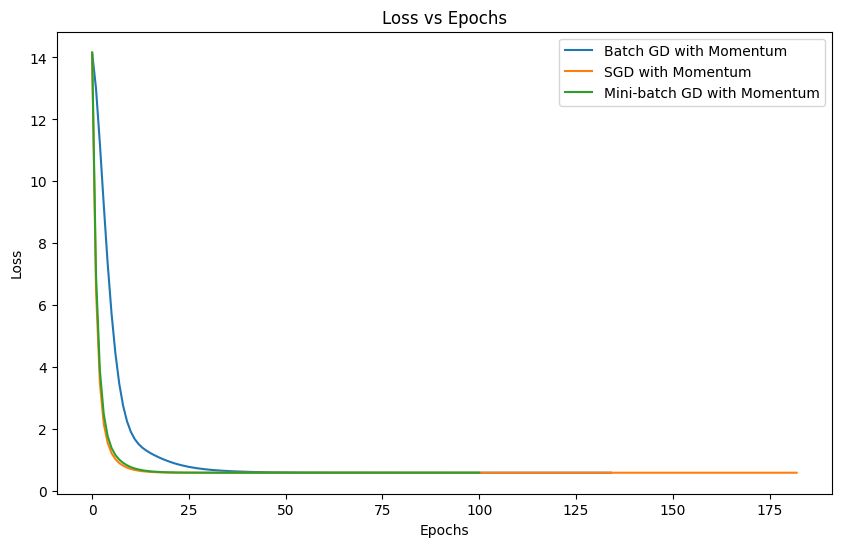

In [168]:
plt.figure(figsize=(10, 6))
plt.plot(loss_batch, label='Batch GD with Momentum')
plt.plot(loss_sgd, label='SGD with Momentum')
plt.plot(loss_mbgd, label='Mini-batch GD with Momentum')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

##Choosing Learning_rate

Vanilla GD

In [169]:
print("Learning rate: ", 0.5)
theta_batch,loss_batch, history_batch, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='batch', n_epochs=2400, learning_rate=0.5)
print()
print("Learning rate: ", 0.1)

theta_batch,loss_batch, history_batch, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='batch', n_epochs=2400, learning_rate=0.1)
print()
print("Learning rate: ", 0.09)
theta_batch,loss_batch, history_batch, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='batch', n_epochs=2400, learning_rate=0.09)
print()
print("Learning rate: ", 0.05)
theta_batch,loss_batch, history_batch, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='batch', n_epochs=2400, learning_rate=0.05)
print()
print("Learning rate: ", 0.01)
theta_batch,loss_batch, history_batch, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='batch', n_epochs=2400, learning_rate=0.01)


Learning rate:  0.5
Converged at epoch 27
No of iters:  27

Learning rate:  0.1
Converged at epoch 176
No of iters:  176

Learning rate:  0.09
Converged at epoch 196
No of iters:  196

Learning rate:  0.05
Converged at epoch 359
No of iters:  359

Learning rate:  0.01
Converged at epoch 1825
No of iters:  1825


SGD

In [170]:
# print("Learning rate: ", 0.5)
# theta_sgd, loss_sgd, history_sgd, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='sgd', n_epochs=1000,  learning_rate=0.5)
# print("Learning rate: ", 0.1)
# theta_sgd, loss_sgd, history_sgd, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='sgd', n_epochs=1000,  learning_rate=0.1)
# print("Learning rate: ", 0.09)
# theta_sgd, loss_sgd, history_sgd, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='sgd', n_epochs=1000,  learning_rate=0.09)
# print("Learning rate: ", 0.05)
# theta_sgd, loss_sgd, history_sgd, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='sgd', n_epochs=1000,  learning_rate=0.05)
# print()
print("Learning rate: ", 0.01)
theta_sgd, loss_sgd, history_sgd, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='sgd', n_epochs=1000,  learning_rate=0.01)
print()
print("Learning rate: ", 0.009)
theta_sgd, loss_sgd, history_sgd, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='sgd', n_epochs=1000,  learning_rate=0.009)
print()
print("Learning rate: ", 0.005)
theta_sgd, loss_sgd, history_sgd, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='sgd', n_epochs=1000,  learning_rate=0.005)
print()
print("Learning rate: ", 0.001)
theta_sgd, loss_sgd, history_sgd, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='sgd', n_epochs=1000,  learning_rate=0.001)

Learning rate:  0.01
Converged at epoch 227
No of iters:  9080

Learning rate:  0.009
Converged at epoch 201
No of iters:  8040

Learning rate:  0.005
Converged at epoch 82
No of iters:  3280

Learning rate:  0.001
Converged at epoch 446
No of iters:  17840


MGBD

In [171]:
print("Learning rate: ", 0.5)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='minibatch', n_epochs=1000,  learning_rate=0.5)
print()
print("Learning rate: ", 0.1)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='minibatch', n_epochs=1000,  learning_rate=0.1)
print()
print("Learning rate: ", 0.09)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='minibatch', n_epochs=1000,  learning_rate=0.09)
print()
print("Learning rate: ", 0.05)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='minibatch', n_epochs=1000,  learning_rate=0.05)
print()
print("Learning rate: ", 0.01)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='minibatch', n_epochs=1000,  learning_rate=0.01)
print()
print("Learning rate: ", 0.009)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='minibatch', n_epochs=1000,  learning_rate=0.009)
print()
print("Learning rate: ", 0.005)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='minibatch', n_epochs=1000,  learning_rate=0.005)
print()
print("Learning rate: ", 0.001)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='minibatch', n_epochs=1000,  learning_rate=0.001)

Learning rate:  0.5

Learning rate:  0.1
Converged at epoch 109
No of iters:  872.0

Learning rate:  0.09
Converged at epoch 97
No of iters:  776.0

Learning rate:  0.05
Converged at epoch 35
No of iters:  280.0

Learning rate:  0.01
Converged at epoch 217
No of iters:  1736.0

Learning rate:  0.009
Converged at epoch 242
No of iters:  1936.0

Learning rate:  0.005
Converged at epoch 437
No of iters:  3496.0

Learning rate:  0.001


Choosing Momentum

Vanilla BG

In [172]:
print("Momentum", 0.09)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='batch', n_epochs=1000,  learning_rate=0.05, momentum=0.09)
print("Momentum", 0.1)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='batch', n_epochs=1000,  learning_rate=0.05, momentum=0.1)
print("Momentum", 0.2)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='batch', n_epochs=1000,  learning_rate=0.05, momentum=0.2)
print("Momentum", 0.3)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='batch', n_epochs=1000,  learning_rate=0.05, momentum=0.3)
print("Momentum", 0.4)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='batch', n_epochs=1000,  learning_rate=0.05, momentum=0.4)

print("Momentum", 0.5)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='batch', n_epochs=1000,  learning_rate=0.05, momentum=0.5)
print("Momentum", 0.6)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='batch', n_epochs=1000,  learning_rate=0.05, momentum=0.6)
print("Momentum", 0.7)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='batch', n_epochs=1000,  learning_rate=0.05, momentum=0.7)

Momentum 0.09
Converged at epoch 471
No of iters:  471
Momentum 0.1
Converged at epoch 466
No of iters:  466
Momentum 0.2
Converged at epoch 413
No of iters:  413
Momentum 0.3
Converged at epoch 359
No of iters:  359
Momentum 0.4
Converged at epoch 305
No of iters:  305
Momentum 0.5
Converged at epoch 250
No of iters:  250
Momentum 0.6
Converged at epoch 193
No of iters:  193
Momentum 0.7
Converged at epoch 133
No of iters:  133


SGD

In [173]:
print("Momentum", 0.09)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='sgd', n_epochs=2000,  learning_rate=0.01, momentum=0.09)
print("Momentum", 0.1)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='sgd', n_epochs=2000,  learning_rate=0.01, momentum=0.1)
print("Momentum", 0.2)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='sgd', n_epochs=2000,  learning_rate=0.01, momentum=0.2)
print("Momentum", 0.3)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='sgd', n_epochs=2000,  learning_rate=0.01, momentum=0.3)
print("Momentum", 0.4)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='sgd', n_epochs=2000,  learning_rate=0.01, momentum=0.4)

print("Momentum", 0.5)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='sgd', n_epochs=2000,  learning_rate=0.01, momentum=0.5)
print("Momentum", 0.6)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='sgd', n_epochs=2000,  learning_rate=0.01, momentum=0.6)
print("Momentum", 0.7)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='sgd', n_epochs=2000,  learning_rate=0.01, momentum=0.7)

Momentum 0.09
Converged at epoch 60
No of iters:  2400
Momentum 0.1
Converged at epoch 95
No of iters:  3800
Momentum 0.2
Converged at epoch 52
No of iters:  2080
Momentum 0.3
Converged at epoch 76
No of iters:  3040
Momentum 0.4
Converged at epoch 120
No of iters:  4800
Momentum 0.5
Converged at epoch 71
No of iters:  2840
Momentum 0.6
Converged at epoch 56
No of iters:  2240
Momentum 0.7
Converged at epoch 722
No of iters:  28880


MGBD

In [174]:
print("Momentum", 0.09)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='minibatch', n_epochs=2000,  learning_rate=0.05, momentum=0.09)
print("Momentum", 0.1)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='minibatch', n_epochs=2000,  learning_rate=0.05, momentum=0.1)
print("Momentum", 0.2)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='minibatch', n_epochs=2000,  learning_rate=0.05, momentum=0.2)
print("Momentum", 0.3)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='minibatch', n_epochs=2000,  learning_rate=0.05, momentum=0.3)
print("Momentum", 0.4)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='minibatch', n_epochs=2000,  learning_rate=0.05, momentum=0.4)

print("Momentum", 0.5)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='minibatch', n_epochs=2000,  learning_rate=0.05, momentum=0.5)
print("Momentum", 0.6)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='minibatch', n_epochs=2000,  learning_rate=0.05, momentum=0.6)
print("Momentum", 0.7)
theta_mgdb, loss_mgdb, history_mgdb, e, i = gradient_descent_with_momentum(x1, y, theta_initial.clone(), method='minibatch', n_epochs=2000,  learning_rate=0.05, momentum=0.7)

Momentum 0.09
Converged at epoch 84
No of iters:  672.0
Momentum 0.1
Converged at epoch 46
No of iters:  368.0
Momentum 0.2
Converged at epoch 96
No of iters:  768.0
Momentum 0.3
Converged at epoch 47
No of iters:  376.0
Momentum 0.4
Converged at epoch 61
No of iters:  488.0
Momentum 0.5
Converged at epoch 124
No of iters:  992.0
Momentum 0.6
Converged at epoch 19
No of iters:  152.0
Momentum 0.7
Converged at epoch 65
No of iters:  520.0
